In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm import tqdm
import pandas as pd

from model.CustomDataSet import CustomDataSetRNN
from model.Tokenizer import SimpleTokenizerV1
from environnement.environnement1Str import Environnement1
from environnement.environnement3Str import Environnement3
from environnement.environnement6Str import Environnement6
from environnement.small_loop import small_loop
from environnement.gridWorld import gridWorld
from model.RNN import LSTM_representation
from inter.simpleInteraction import simpleInteraction as inter
from outil import *

In [2]:
def get_data(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

def get_data_without_fell_front(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        all_action:list = env.get_actions()
        all_action.remove("feel_front")
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


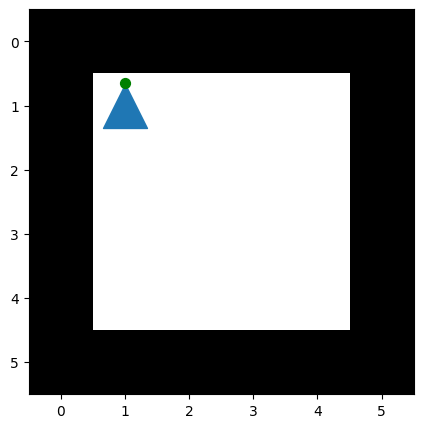

In [3]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []
env_test.display_world()

In [4]:
list_vocab = ['<pad>', '<Masked>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    list_vocab.append(act)
for fb in env_test.get_outcomes():
    list_vocab.append(fb)

for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

<pad>
<Masked>
forward
turn_left
turn_right
feel_front
feel_left
feel_right
wall
empty
{'<pad>': 0, '<Masked>': 1, 'forward': 2, 'turn_left': 3, 'turn_right': 4, 'feel_front': 5, 'feel_left': 6, 'feel_right': 7, 'wall': 8, 'empty': 9}


# X and Y
Sur un exemple simple avec 10 actions sur un environment nous avons :

In [5]:
data_brut_y = get_data_without_fell_front(env_test, tokenizer, n_episodes=10)
print("data_train", data_brut_y)
data_y = torch.tensor(data_brut_y)
data_y = data_y.unsqueeze(0)


data_train [6, 8, 2, 8, 4, 9, 3, 9, 3, 9, 4, 9, 6, 8, 3, 9, 7, 8, 7, 8]


In [6]:
data_brut_y = [data_brut_y]

In [7]:
for i in range(1000):
    data_brut_y.append(get_data_without_fell_front(env_test, tokenizer, n_episodes=10))

data_y = torch.tensor(data_brut_y)

data_y est alors notre Y. Pour obtenir notre X, nous utiliserons un token Dropen

In [8]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [9]:
td = TokenDrop(0.15, pad_token=0, num_special=2)
data_x = td(data_y)
print("data_x", data_x)

data_x tensor([[0, 8, 0,  ..., 8, 7, 8],
        [3, 9, 0,  ..., 9, 3, 9],
        [3, 9, 0,  ..., 9, 3, 9],
        ...,
        [4, 9, 2,  ..., 8, 2, 0],
        [4, 9, 7,  ..., 8, 6, 9],
        [7, 8, 0,  ..., 8, 4, 9]])


Notre x est donc data_x. Maintenant nous voulons que notre model arrive à obvenir un représentation de la séquence pour réussir a compléter les 0.

# Multi tasks ?
On peut vouloir un encoder qui apprend a encoder pour deviner les actions, et un encoder qui apprends a deviner les observations.


In [10]:
class TokenDropEven(nn.Module):
    """For a batch of tokens indices, randomly replace a non-special token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        super().__init__()
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        """Mask only action (even if it is not a special token) for a batch of samples."""
        sample_out = torch.empty_like(sample)
        for i, single_sample in enumerate(sample):
            even_sample = single_sample[::2]
            odd_sample = single_sample[1::2]
            
            # Generate mask for even elements
            mask = torch.bernoulli(self.prob * torch.ones_like(even_sample)).long()
            can_drop = (even_sample >= self.num_special).long()
            mask = mask * can_drop
            
            # Replace masked elements with <pad>
            replace_with = (self.pad_token * torch.ones_like(even_sample)).long()
            even_sample_out = (1 - mask) * even_sample + mask * replace_with
            
            # Recombine even and odd elements
            sample_out[i, ::2] = even_sample_out
            sample_out[i, 1::2] = odd_sample
        
        return sample_out

In [11]:
td = TokenDropEven(0.9, pad_token=0, num_special=2)
data_x = td(data_y)
print("data_x", data_x)
print("data_y", data_y)

data_x tensor([[0, 8, 0,  ..., 8, 0, 8],
        [0, 9, 0,  ..., 9, 0, 9],
        [0, 9, 0,  ..., 9, 0, 9],
        ...,
        [0, 9, 0,  ..., 8, 0, 8],
        [0, 9, 0,  ..., 8, 0, 9],
        [0, 8, 0,  ..., 8, 0, 9]])
data_y tensor([[6, 8, 2,  ..., 8, 7, 8],
        [3, 9, 4,  ..., 9, 3, 9],
        [3, 9, 6,  ..., 9, 3, 9],
        ...,
        [4, 9, 2,  ..., 8, 2, 8],
        [4, 9, 7,  ..., 8, 6, 9],
        [7, 8, 3,  ..., 8, 4, 9]])


In [12]:
class TokenDropOdd(nn.Module):
    """For a batch of tokens indices, randomly replace a non-special token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        super().__init__()
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        """Mask only action (even if it is not a special token) for a batch of samples."""
        sample_out = torch.empty_like(sample)
        for i, single_sample in enumerate(sample):
            even_sample = single_sample[::2]
            odd_sample = single_sample[1::2]
            
            # Generate mask for even elements
            mask = torch.bernoulli(self.prob * torch.ones_like(odd_sample)).long()
            can_drop = (odd_sample >= self.num_special).long()
            mask = mask * can_drop
            
            # Replace masked elements with <pad>
            replace_with = (self.pad_token * torch.ones_like(odd_sample)).long()
            old_sample_out = (1 - mask) * odd_sample + mask * replace_with
            
            # Recombine even and odd elements
            sample_out[i, ::2] = even_sample 
            sample_out[i, 1::2] = old_sample_out
        
        return sample_out

In [13]:
td = TokenDropOdd(0.9, pad_token=0, num_special=2)
data_x = td(data_y)
print("data_x", data_x)
print("data_y", data_y)

data_x tensor([[6, 0, 2,  ..., 0, 7, 0],
        [3, 0, 4,  ..., 0, 3, 0],
        [3, 0, 6,  ..., 0, 3, 0],
        ...,
        [4, 0, 2,  ..., 0, 2, 0],
        [4, 0, 7,  ..., 8, 6, 0],
        [7, 0, 3,  ..., 0, 4, 0]])
data_y tensor([[6, 8, 2,  ..., 8, 7, 8],
        [3, 9, 4,  ..., 9, 3, 9],
        [3, 9, 6,  ..., 9, 3, 9],
        ...,
        [4, 9, 2,  ..., 8, 2, 8],
        [4, 9, 7,  ..., 8, 6, 9],
        [7, 8, 3,  ..., 8, 4, 9]])


In [14]:
class CustomDataSet(Dataset):
    def __init__(self, data:list[list]):
        self.data = torch.tensor(data)
        print(self.data)

    def __len__(self):
        return self.data.size()[1]

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
data_set = CustomDataSet(data_brut_y)

print("len data_set", data_set.__len__())
print("data_set 1", data_set[0])

tensor([[6, 8, 2,  ..., 8, 7, 8],
        [3, 9, 4,  ..., 9, 3, 9],
        [3, 9, 6,  ..., 9, 3, 9],
        ...,
        [4, 9, 2,  ..., 8, 2, 8],
        [4, 9, 7,  ..., 8, 6, 9],
        [7, 8, 3,  ..., 8, 4, 9]])
len data_set 20
data_set 1 tensor([6, 8, 2, 8, 4, 9, 3, 9, 3, 9, 4, 9, 6, 8, 3, 9, 7, 8, 7, 8])


In [16]:
data_loader = DataLoader(data_y, batch_size=2, shuffle=True)

In [17]:
for i, data in enumerate(data_loader):
    print("batch", i)
    print(data)
    data_x = td(data)
    print("data_x", data_x)

print(data_y)

batch 0
tensor([[4, 9, 3, 9, 7, 9, 7, 9, 3, 9, 4, 9, 3, 9, 7, 9, 4, 9, 7, 9],
        [3, 9, 6, 9, 6, 9, 2, 9, 6, 9, 2, 9, 6, 9, 6, 9, 7, 8, 4, 9]])
data_x tensor([[4, 0, 3, 9, 7, 0, 7, 0, 3, 0, 4, 0, 3, 0, 7, 0, 4, 0, 7, 0],
        [3, 0, 6, 0, 6, 0, 2, 0, 6, 0, 2, 0, 6, 0, 6, 0, 7, 8, 4, 0]])
batch 1
tensor([[2, 9, 4, 9, 6, 9, 2, 8, 2, 8, 3, 9, 2, 9, 3, 9, 7, 9, 3, 9],
        [3, 9, 3, 9, 2, 8, 4, 9, 2, 8, 2, 8, 7, 9, 7, 9, 2, 8, 4, 9]])
data_x tensor([[2, 0, 4, 0, 6, 0, 2, 0, 2, 0, 3, 0, 2, 0, 3, 0, 7, 9, 3, 0],
        [3, 0, 3, 0, 2, 0, 4, 0, 2, 0, 2, 0, 7, 0, 7, 9, 2, 0, 4, 0]])
batch 2
tensor([[4, 9, 3, 9, 2, 8, 7, 9, 4, 9, 3, 9, 4, 9, 6, 8, 4, 9, 3, 9],
        [4, 9, 2, 9, 6, 9, 7, 9, 7, 9, 4, 9, 2, 9, 6, 9, 4, 9, 4, 9]])
data_x tensor([[4, 0, 3, 0, 2, 8, 7, 0, 4, 0, 3, 0, 4, 0, 6, 0, 4, 0, 3, 0],
        [4, 9, 2, 0, 6, 9, 7, 0, 7, 0, 4, 0, 2, 0, 6, 0, 4, 0, 4, 0]])
batch 3
tensor([[3, 9, 3, 9, 4, 9, 6, 9, 3, 9, 2, 9, 6, 9, 6, 9, 4, 9, 6, 9],
        [3, 9, 3, 9, 6, 9, 4, 9

In [18]:
def train(model: nn.Module, data_loader_train: DataLoader, nb_epoch: int, optimizer, loss_fn):
    td = TokenDrop(0.15, pad_token=0, num_special=2)
    td_act = TokenDropOdd(0.25, pad_token=0, num_special=2)
    td_fb = TokenDropEven(0.25, pad_token=0, num_special=2)

    model.train()
    acc = 0
    total_loss = 0
    for j in tqdm(range(nb_epoch), desc=f"Training acc : {acc} loss {total_loss}", unit="epoch"):
        for i, data in enumerate(data_loader_train):
            data_mask_act = td_act(data)
            data_mask_fb = td_fb(data)
            bs = data.shape[0]
            # print("batch size ", bs)

            # Initialize the memory buffers
            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size)
            # print(f'shape hidden and memory {hidden.shape} | {memory.shape}')
            total_loss = 0  # Accumulate loss over both tasks

            for tasks in [data_mask_act, data_mask_fb]:
                # Forward pass
                proba, hidden, memory = model(tasks, hidden, memory)
                proba = proba.transpose(1, 2)
                pred = proba.argmax(dim=1)
                if j == nb_epoch - 1:
                    print("tasks : ", tasks)
                    print("prediction : ", pred)
                    print("goal : ", data)
                    
                    print("loss", loss)
                pad_mask = (tasks == 0)
                correct = (pred == data) & pad_mask
                acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
                # print("accuracy", acc)
                    
                # print("proba size", proba.size())
                # print("data", data)
                # print("data size", data.size())
                
                loss = loss_fn(proba, data)  # Use proba instead of pred
                total_loss += loss  # Accumulate loss   
            # print("total_loss", total_loss)
            # Backward pass and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()


In [19]:
num_layers = 1
hidden_size = 128
temp = 1.0
model = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.1
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [20]:
train(
    model=model,
    data_loader_train=data_loader,
    nb_epoch=30,
    optimizer=optimizer,
    loss_fn=loss_fn
)

Training acc : 0 loss 0:  97%|█████████▋| 29/30 [01:51<00:03,  3.90s/epoch]

tasks :  tensor([[6, 9, 2, 0, 6, 0, 4, 9, 3, 9, 4, 9, 6, 9, 2, 9, 6, 0, 3, 9],
        [7, 0, 6, 0, 6, 0, 7, 0, 7, 9, 3, 9, 6, 9, 4, 9, 6, 9, 4, 0]])
prediction :  tensor([[6, 9, 2, 9, 6, 9, 4, 9, 3, 9, 4, 9, 6, 9, 2, 9, 6, 9, 3, 9],
        [7, 9, 6, 9, 6, 9, 7, 9, 7, 9, 3, 9, 6, 9, 4, 9, 6, 9, 4, 9]])
goal :  tensor([[6, 9, 2, 9, 6, 9, 4, 9, 3, 9, 4, 9, 6, 9, 2, 9, 6, 9, 3, 9],
        [7, 9, 6, 9, 6, 9, 7, 9, 7, 9, 3, 9, 6, 9, 4, 9, 6, 9, 4, 9]])
loss tensor(0.2684, grad_fn=<NllLoss2DBackward0>)
tasks :  tensor([[6, 9, 2, 9, 0, 9, 4, 9, 0, 9, 4, 9, 6, 9, 2, 9, 6, 9, 3, 9],
        [7, 9, 6, 9, 6, 9, 0, 9, 7, 9, 3, 9, 6, 9, 0, 9, 6, 9, 0, 9]])
prediction :  tensor([[6, 9, 2, 9, 6, 9, 4, 9, 6, 9, 4, 9, 6, 9, 2, 9, 6, 9, 3, 9],
        [7, 9, 6, 9, 6, 9, 6, 9, 7, 9, 3, 9, 6, 9, 6, 9, 6, 9, 6, 9]])
goal :  tensor([[6, 9, 2, 9, 6, 9, 4, 9, 3, 9, 4, 9, 6, 9, 2, 9, 6, 9, 3, 9],
        [7, 9, 6, 9, 6, 9, 7, 9, 7, 9, 3, 9, 6, 9, 4, 9, 6, 9, 4, 9]])
loss tensor(0.0149, grad_fn=<NllLoss2DBack

Training acc : 0 loss 0: 100%|██████████| 30/30 [01:55<00:00,  3.86s/epoch]

tensor(0.0290, grad_fn=<NllLoss2DBackward0>)
tasks :  tensor([[2, 9, 7, 9, 7, 9, 3, 9, 2, 8, 4, 9, 4, 9, 2, 9, 2, 9, 4, 9],
        [3, 9, 3, 9, 0, 8, 0, 8, 6, 8, 7, 9, 0, 9, 4, 9, 4, 9, 3, 9]])
prediction :  tensor([[2, 9, 7, 9, 7, 9, 3, 9, 2, 8, 4, 9, 4, 9, 2, 9, 2, 9, 4, 9],
        [3, 9, 3, 9, 6, 8, 6, 8, 6, 8, 7, 9, 4, 9, 4, 9, 4, 9, 3, 9]])
goal :  tensor([[2, 9, 7, 9, 7, 9, 3, 9, 2, 8, 4, 9, 4, 9, 2, 9, 2, 9, 4, 9],
        [3, 9, 3, 9, 6, 8, 6, 8, 6, 8, 7, 9, 7, 9, 4, 9, 4, 9, 3, 9]])
loss tensor(0.0002, grad_fn=<NllLoss2DBackward0>)
tasks :  tensor([[4, 0, 6, 8, 2, 0, 4, 9, 3, 9, 2, 8, 2, 8, 3, 9, 6, 0, 3, 9],
        [6, 9, 4, 9, 7, 0, 2, 8, 6, 8, 3, 0, 3, 0, 3, 9, 3, 9, 2, 0]])
prediction :  tensor([[4, 9, 6, 8, 2, 8, 4, 9, 3, 9, 2, 8, 2, 8, 3, 9, 6, 9, 3, 9],
        [6, 9, 4, 9, 7, 9, 2, 8, 6, 8, 3, 9, 3, 9, 3, 9, 3, 9, 2, 9]])
goal :  tensor([[4, 9, 6, 8, 2, 9, 4, 9, 3, 9, 2, 8, 2, 8, 3, 9, 6, 9, 3, 9],
        [6, 9, 4, 9, 7, 9, 2, 8, 6, 8, 3, 9, 3, 9, 3, 9, 3, 9, 2, 8]

In [21]:
env_test_manu = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

action = []
outcome = []
all_seq = []
list_act_to_make = ['turn_right', 'forward', 'turn_left', 'forward', 'feel_right']

for act in list_act_to_make:
    action.append(act)
    outcome.append(env_test_manu.outcome(action[-1]))
    env_test_manu.save_world(path='imgToGif')
    all_seq += tokenizer.encode([action[-1], outcome[-1]])

print("Action : ", action)
print("Outcome : ", outcome)
print("all_seq : ", all_seq)

# We add one action exemple feel left


The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
Action :  ['turn_right', 'forward', 'turn_left', 'forward', 'feel_right']
Outcome :  ['empty', 'empty', 'empty', 'wall', 'empty']
all_seq :  [4, 9, 2, 9, 3, 9, 2, 8, 7, 9]


In [22]:
prompt = all_seq.copy()
prompt += tokenizer.encode(['feel_front', "<pad>"])

hidden = torch.zeros(2 * model.num_layers, 1, model.hidden_size)
memory = torch.zeros(2 * model.num_layers, 1, model.hidden_size)

prompt = torch.tensor(prompt)
prompt = prompt.unsqueeze(0)
proba, hidden, memory = model(prompt, hidden, memory)

proba = proba.transpose(1, 2)
pred = proba.argmax(dim=1)
print("proba", proba)
print("prediction", pred)
print(tokenizer.decode(pred[0].tolist()))

proba tensor([[[ -7.9065, -11.0765,  -7.7904, -10.5303,  -7.8240, -11.8485,  -7.3124,
           -8.3798,  -8.9573,  -7.7094,  -9.9692, -12.1145],
         [ -8.4868, -11.8595,  -8.4000, -11.4849,  -8.6621, -12.5567,  -7.7906,
           -9.0534, -10.5099,  -8.6927, -11.1901, -12.3760],
         [ -1.1820,  -1.5519,  10.5645,  -3.3745,  -2.2386,  -3.5705,  11.6975,
           -3.4677,  -0.6105,  -2.6956,  -2.4139,  -2.8295],
         [  1.7395,  -2.0320,  -0.0695,  -2.3372,   9.8533,  -3.3060,  -1.3891,
           -3.4496,   1.4467,  -1.7203,   2.1525,  -2.3607],
         [ 12.4813,  -3.4914,  -2.3550,  -3.6646,  -0.6923,  -4.7227,  -2.5238,
           -2.6686,   1.4955,  -3.5839,   7.0484,  -3.9099],
         [ -8.3537, -11.1890,  -7.8859, -10.6088,  -7.7699, -11.4543,  -7.1507,
           -8.0576, -10.0318,  -8.3356, -10.2471, -11.2156],
         [ -2.6946,  -6.7723,  -2.0993,  -6.8791,  -3.1915,  -4.0945,  -1.5928,
           -2.7277,  -4.2316,  -6.3165,  -4.9920,  -4.1685],
       

In [23]:
env_test_manu = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

action = []
outcome = []
all_seq = []
list_act_to_make = ['turn_right', 'forward', 'forward', 'forward', 'turn_left', 'turn_left', 'forward', 'feel_right', 'turn_right', 'feel_left']

for act in list_act_to_make:
    action.append(act)
    outcome.append(env_test_manu.outcome(action[-1]))
    env_test_manu.save_world(path='imgToGif2')
    all_seq += tokenizer.encode([action[-1], outcome[-1]])

print("Action : ", action)
print("Outcome : ", outcome)
print("all_seq : ", all_seq)

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
Action :  ['turn_right', 'forward', 'forward', 'forward', 'turn_left', 'turn_left', 'forward', 'feel_right', 'turn_right', 'feel_left']
Outcome :  ['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'wall', 'empty', 'empty']
all_seq :  [4, 9, 2, 9, 2, 9, 2, 9, 3, 9, 3, 9, 2, 9, 7, 8, 4, 9, 6, 9]


In [24]:
# We add one action exemple feel left
prompt = all_seq.copy()
prompt += tokenizer.encode(["feel_left", "<pad>"])
prompt = prompt[-10:]
print('prompt ', prompt)

hidden = torch.zeros(2 * model.num_layers, 1, model.hidden_size)
memory = torch.zeros(2 * model.num_layers, 1, model.hidden_size)

prompt_tensor = torch.tensor(prompt)
prompt_tensor = prompt_tensor.unsqueeze(0)
proba, hidden, memory = model(prompt_tensor, hidden, memory)

proba = proba.transpose(1, 2)
pred = proba.argmax(dim=1)
print("proba", proba)
print("prediction", pred)
print(tokenizer.decode(pred[0].tolist()))
print(tokenizer.decode(prompt_tensor[0].tolist()))

prompt  [2, 9, 7, 8, 4, 9, 6, 9, 6, 0]
proba tensor([[[ -8.5960, -12.1582, -10.5950,  -5.7878,  -4.6228,  -9.4840,  -5.5499,
          -12.1021,  -4.1791,  -9.7366],
         [ -9.5549, -12.9537, -11.2903,  -5.7929,  -4.8969, -10.1277,  -6.3495,
          -12.4287,  -5.3474, -10.6897],
         [ 10.7974,  -2.7485,   0.2565,  -4.6943,  -3.8360,  -2.8839,  -0.8405,
           -4.0793,  -0.6352,  -2.6790],
         [  1.1748,  -3.0764,  -3.1158,  -2.0680,   1.1795,  -2.1100,  -1.4516,
           -4.1023,  -2.0746,  -4.1491],
         [ -0.2928,  -3.3443,  -2.0061,   0.3289,  10.6966,  -3.0147,  -0.9954,
           -4.5909,  -0.4380,  -5.7587],
         [ -8.7788, -12.6726, -11.1602,  -5.6537,  -4.3750,  -9.1471,  -5.5500,
          -11.6732,  -4.3841, -10.0647],
         [ -0.4277,  -6.2630,  -2.7187,  -2.7455,  -2.3818,  -4.5713,  11.3682,
           -4.7376,  11.6407,  -6.3069],
         [ -2.3250,  -3.5700,  11.7474,  -3.8279,  -1.4271,  -4.7440,  -2.7272,
           -3.8692,  -2.8370